## Generate Logits and Embeddings to use as Features for Tweet Classifier

Given a labeled training and unlabeled test set of tweets, this notebook fine-tunes a pre-trained BERT model and generates embeddings and logtis to use as features in a stacked model.

To generate features on the training set, the training set will be divided into 8 holdouts, and a new model will be trained on 7 holdouts at a time to generate the logits and embeddings for the other holdout.

To generate features on the test set, the model will be trained on the entire training set and used to generate features for the entire test set at once.

In [0]:
import random
import os
import pandas as pd
import numpy as np
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, BertPreTrainedModel, BertConfig
from transformers import AdamW, BertConfig, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, Subset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files, drive
drive.mount('/content/drive')
uploaded = files.upload()

In [0]:
df_train = pd.read_csv(io.StringIO(uploaded['profile_data_train.csv'].decode('utf-8')))
df_train = df_train.drop('Unnamed: 0', axis=1).reset_index(drop=True)

df_test = pd.read_csv(io.StringIO(uploaded['profile_data_test.csv'].decode('utf-8')))
df_test = df_test.drop('Unnamed: 0', axis=1).reset_index(drop=True)

Split training set into 8 holdouts, generate X/Y variables.

In [0]:
# Split train dataframe into 8 stratified chunks
X_train = df_train.drop('age_group', axis=1)
Y_train = df_train.age_group.values.tolist()
X_test = df_test.drop('age_group', axis=1)
Y_test = df_test.age_group.values.tolist()

# First split: 50-50
X_1, X_2, Y_1, Y_2 = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.5, random_state=42)

# Second split: 25-25-25-25
X_1, X_3, Y_1, Y_3 = train_test_split(X_1, Y_1, stratify=Y_1, test_size=0.5, random_state=42)
X_2, X_4, Y_2, Y_4 = train_test_split(X_2, Y_2, stratify=Y_2, test_size=0.5, random_state=42)

# Third split: 12.5 x 8
X_1, X_5, Y_1, Y_5 = train_test_split(X_1, Y_1, stratify=Y_1, test_size=0.5, random_state=42)
X_2, X_6, Y_2, Y_6 = train_test_split(X_2, Y_2, stratify=Y_2, test_size=0.5, random_state=42)
X_3, X_7, Y_3, Y_7 = train_test_split(X_3, Y_3, stratify=Y_3, test_size=0.5, random_state=42)
X_4, X_8, Y_4, Y_8 = train_test_split(X_4, Y_4, stratify=Y_4, test_size=0.5, random_state=42)

X_1 = X_1.reset_index(drop=True)
X_2 = X_2.reset_index(drop=True)
X_3 = X_3.reset_index(drop=True)
X_4 = X_4.reset_index(drop=True)
X_5 = X_5.reset_index(drop=True)
X_6 = X_6.reset_index(drop=True)
X_7 = X_7.reset_index(drop=True)
X_8 = X_8.reset_index(drop=True)

X_splits = [X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8]
Y_splits = [Y_1, Y_2, Y_3, Y_4, Y_5, Y_6, Y_7, Y_8]

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Define functions to train, evaluate, and get outputs for a fine-tuned BERT

In [0]:
# Compute accuracy given logits and true labels
def accuracy(logits, labels):
    preds = np.argmax(logits, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(preds == labels) / len(labels)

# Train a model over one epoch
def train_one_epoch(model, train_dataloader, optimizer, scheduler):
    print("*************STARTING EPOCH*************")
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    total_loss = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Epoch
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0:
            print("Batch " + str(step) + ' of ' + str(len(train_dataloader)))
        batch_input_ids = batch[0].to(device)
        batch_input_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_masks, labels=batch_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Done training epoch. Average training loss: " + str(avg_train_loss))
    return avg_train_loss

# Evaluate a model's accuracy and return predictions, true labels, embeddings
def eval_profiles(model, test_dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions, true_labels, embedding_layers = [], [], []

    eval_accuracy, eval_steps = 0, 0

    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        if step % 100 == 0:
            print("batch " + str(step) + ' of ' + str(len(test_dataloader)))
        batch_input_ids, batch_input_mask, batch_labels = batch
        with torch.no_grad():
            outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        labels = batch_labels.to('cpu').numpy()
        embed = outputs[1][-1].detach().cpu().numpy() # Last layer before logits
        predictions.append(logits)
        true_labels.append(labels)
        embedding_layers.append(embed)
        eval_accuracy += accuracy(logits, labels)
        eval_steps += 1

    print("Calculated accuracy on eval set: " + str(eval_accuracy / eval_steps))
    return predictions, true_labels, embedding_layers

In [0]:
# Assign initial training logits
df_train = df_train.assign(Logit0=np.zeros(df_train.shape[0]))
df_train = df_train.assign(Logit1=np.zeros(df_train.shape[0]))
df_train = df_train.assign(Logit2=np.zeros(df_train.shape[0]))
df_train = df_train.assign(Logit3=np.zeros(df_train.shape[0]))

Generate logits and embeddings for each holdout by training on the others

************************************************************************************************************
************************************GENERATING LOGITS FOR HOLDOUT 1 OF 8************************************
************************************************************************************************************




Epoch 1
*************STARTING EPOCH*************
Batch 0 of 186


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Batch 100 of 186
Done training epoch. Average training loss: 1.1985201300472341
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.9267382572094599
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.6490305994627297
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.39485938710871565
Epoch 5
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.18592819448320136
Epoch 6
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.054078109297020144
Epoch 7
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.022619281151902773


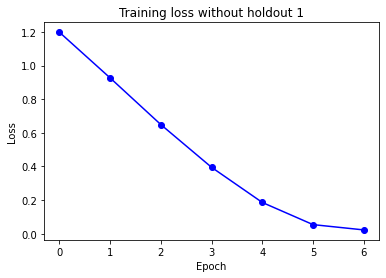

batch 0 of 27
Calculated accuracy on eval set: 0.47685185185185186
************************************************************************************************************
************************************GENERATING LOGITS FOR HOLDOUT 2 OF 8************************************
************************************************************************************************************

Epoch 1
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 1.2079175515200502
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.9444932022722818
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.5919571495665017
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.3065184117645346
Epoch 5
*************STARTING

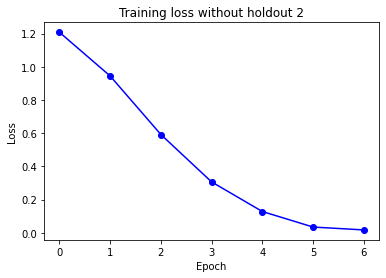

batch 0 of 27
Calculated accuracy on eval set: 0.5185185185185185
************************************************************************************************************
************************************GENERATING LOGITS FOR HOLDOUT 3 OF 8************************************
************************************************************************************************************

Epoch 1
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 1.208329483386009
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.9595490609125424
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.6110440143333968
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.3332428754737941
Epoch 5
*************STARTING E

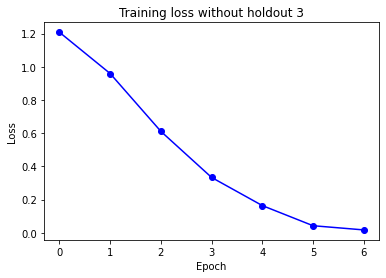

batch 0 of 27
Calculated accuracy on eval set: 0.5370370370370371
************************************************************************************************************
************************************GENERATING LOGITS FOR HOLDOUT 4 OF 8************************************
************************************************************************************************************

Epoch 1
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 1.2061449154730766
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.9153922360430482
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.5761502807339033
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.30978118812525146
Epoch 5
*************STARTING

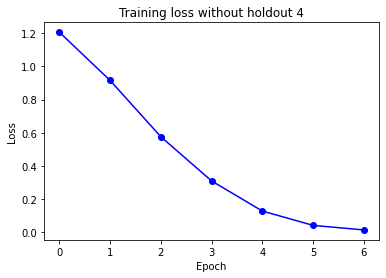

batch 0 of 27
Calculated accuracy on eval set: 0.4722222222222222
************************************************************************************************************
************************************GENERATING LOGITS FOR HOLDOUT 5 OF 8************************************
************************************************************************************************************

Epoch 1
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 1.2120276788870494
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.9384861490739289
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.6189236010434807
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.3484393509645616
Epoch 5
*************STARTING 

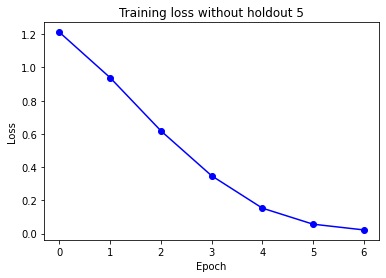

batch 0 of 27
Calculated accuracy on eval set: 0.5462962962962963
************************************************************************************************************
************************************GENERATING LOGITS FOR HOLDOUT 6 OF 8************************************
************************************************************************************************************

Epoch 1
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 1.2151711595955716
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.9561460594977101
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.6422312001707733
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.4068613084413672
Epoch 5
*************STARTING 

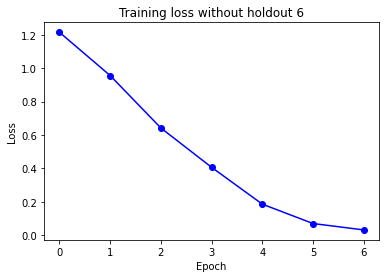

batch 0 of 27
Calculated accuracy on eval set: 0.5351851851851852
************************************************************************************************************
************************************GENERATING LOGITS FOR HOLDOUT 7 OF 8************************************
************************************************************************************************************

Epoch 1
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 1.202116492294496
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.9693838971596892
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.7240425231315757
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.46299800124540125
Epoch 5
*************STARTING 

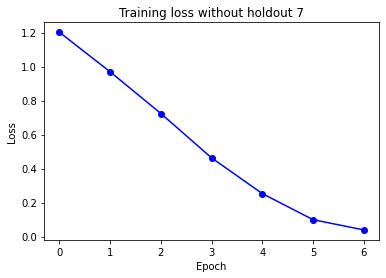

batch 0 of 27
Calculated accuracy on eval set: 0.5407407407407407
************************************************************************************************************
************************************GENERATING LOGITS FOR HOLDOUT 8 OF 8************************************
************************************************************************************************************

Epoch 1
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 1.187458702953913
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.9417789123391592
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.667666224382257
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 186
Batch 100 of 186
Done training epoch. Average training loss: 0.4221239566642751
Epoch 5
*************STARTING EP

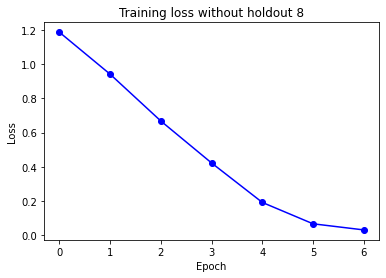

batch 0 of 27
Calculated accuracy on eval set: 0.5157407407407407


In [0]:
epochs = 7
batch_size = 8

for holdout_idx in range(8):
  print("************************************************************************************************************")
  print("************************************GENERATING LOGITS FOR HOLDOUT " + str(holdout_idx + 1) + " OF 8************************************")
  print("************************************************************************************************************\n")
  X_temp, Y_temp = [], []
  X_holdout, Y_holdout = [], []
  # Generate temporary X and Y for training and holdout
  for idx in range(8):
    if idx != holdout_idx:
      X_temp = X_temp + X_splits[idx].tweets_text.values.tolist()
      Y_temp = Y_temp + Y_splits[idx]
    else:
      X_holdout = X_splits[idx].tweets_text.values.tolist()
      Y_holdout = Y_splits[idx]
  
  # Tokenize and pad inputs
  input_ids, holdout_input_ids = [], []

  for tweet in X_temp:
    encoded = tokenizer.encode(tweet, add_special_tokens=True, max_length=512)
    input_ids.append(encoded)
  input_ids = pad_sequences(input_ids, maxlen=512, dtype='long', value=0, padding='post', truncating='post')

  for tweet in X_holdout:
    encoded = tokenizer.encode(tweet, add_special_tokens=True, max_length=512)
    holdout_input_ids.append(encoded)
  holdout_input_ids = pad_sequences(holdout_input_ids, maxlen=512, dtype='long', value=0, padding='post', truncating='post')

  # Attention masks to ignore padded tokens
  attention_masks, holdout_attention_masks = [], []
  for tweet in input_ids:
    mask = [int(token_id > 0) for token_id in tweet]
    attention_masks.append(mask)

  for tweet in holdout_input_ids:
    mask = [int(token_id > 0) for token_id in tweet]
    holdout_attention_masks.append(mask)
  
  # Prep torch data
  train_inputs = torch.tensor(input_ids)
  train_labels = torch.tensor(Y_temp)
  train_masks = torch.tensor(attention_masks)
  holdout_inputs = torch.tensor(holdout_input_ids)
  holdout_labels = torch.tensor(Y_holdout)
  holdout_masks = torch.tensor(holdout_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  holdout_data = TensorDataset(holdout_inputs, holdout_masks, holdout_labels)
  holdout_dataloader = DataLoader(holdout_data, sampler=None, batch_size=batch_size)

  # Load empty model
  model =  BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4, output_attentions=False, output_hidden_states=True)
  model.cuda()
  optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  # Train over epochs
  losses = []
  for epoch in range(epochs):
    print("Epoch " + str(epoch + 1))
    loss = train_one_epoch(model, train_dataloader, optimizer, scheduler)
    losses.append(loss)

  plt.plot(losses, 'b-o')
  plt.title("Training loss without holdout " + str(holdout_idx + 1))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
  
  predictions, true_labels, embedding_layers = eval_profiles(model, holdout_dataloader)

  # Assign logits and embeddings to dataframe
  logits = [item for sublist in predictions for item in sublist]
  logits = np.array(logits)
  embeddings = np.array([item for sublist in embedding_layers for item in sublist]) # N x 512 x 768
  embeddings = embeddings[:,0,:]  # Embedding of [CLS] token represents sentence, N x 768

  X_splits[holdout_idx] = X_splits[holdout_idx].reset_index(drop=True)
  for idx, row in X_splits[holdout_idx].iterrows():
    handle = row['handle']
    df_train.loc[df_train['handle'] == handle, 'Logit0'] = logits[idx][0]
    df_train.loc[df_train['handle'] == handle, 'Logit1'] = logits[idx][1]
    df_train.loc[df_train['handle'] == handle, 'Logit2'] = logits[idx][2]
    df_train.loc[df_train['handle'] == handle, 'Logit3'] = logits[idx][3]
    for i in range(768):
      feat_name = 'embed' + str(i)
      df_train.loc[df_train['handle'] == handle, feat_name] = embeddings[idx][i]
  
  del model # Free cuda memory, prevent information leakage

In [0]:
# Save generated training features
df_train.to_csv('train.csv')
!cp train.csv "drive/My Drive/"

print("Successfully saved training features:")
print(df_train.head())

Successfully saved training features:
           handle  ...  embed767
0      labworxart  ... -0.565820
1  SavannahSoutas  ... -0.092007
2        chaaitee  ... -0.338629
3      sofieeeeya  ... -0.002130
4     aalexmoran_  ...  0.338243

[5 rows x 789 columns]


Now generate logits and embeddings for test set by training on entire train set.

Epoch 1
*************STARTING EPOCH*************
Batch 0 of 213
Batch 100 of 213
Batch 200 of 213
Done training epoch. Average training loss: 1.1853205046743294
Epoch 2
*************STARTING EPOCH*************
Batch 0 of 213
Batch 100 of 213
Batch 200 of 213
Done training epoch. Average training loss: 0.9245982973228598
Epoch 3
*************STARTING EPOCH*************
Batch 0 of 213
Batch 100 of 213
Batch 200 of 213
Done training epoch. Average training loss: 0.679994402566986
Epoch 4
*************STARTING EPOCH*************
Batch 0 of 213
Batch 100 of 213
Batch 200 of 213
Done training epoch. Average training loss: 0.45721563619906913
Epoch 5
*************STARTING EPOCH*************
Batch 0 of 213
Batch 100 of 213
Batch 200 of 213
Done training epoch. Average training loss: 0.20991387123792943
Epoch 6
*************STARTING EPOCH*************
Batch 0 of 213
Batch 100 of 213
Batch 200 of 213
Done training epoch. Average training loss: 0.06912021735079692
Epoch 7
*************STARTING EP

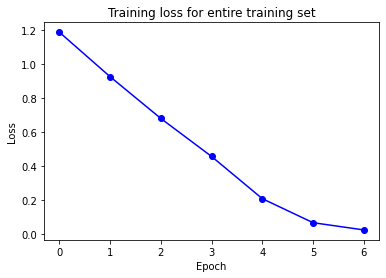

batch 0 of 54
Calculated accuracy on eval set: 0.5069444444444444


In [0]:
input_ids = []

for tweet in X_train.tweets_text.values.tolist():
  encoded = tokenizer.encode(tweet, add_special_tokens=True, max_length=512)
  input_ids.append(encoded)

input_ids = pad_sequences(input_ids, maxlen=512, dtype='long', value=0, padding='post', truncating='post')
attention_masks = []
for tweet in input_ids:
  mask = [int(token_id > 0) for token_id in tweet]
  attention_masks.append(mask)

train_inputs = torch.tensor(input_ids)
train_labels = torch.tensor(Y_train)
train_masks = torch.tensor(attention_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Load empty model
model =  BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4, output_attentions=False, output_hidden_states=True)
model.cuda()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train over epochs
losses = []
for epoch in range(epochs):
  print("Epoch " + str(epoch + 1))
  loss = train_one_epoch(model, train_dataloader, optimizer, scheduler)
  losses.append(loss)

plt.plot(losses, 'b-o')
plt.title("Training loss for entire training set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

test_input_ids = []

for tweet in X_test.tweets_text.values.tolist():
  encoded = tokenizer.encode(tweet, add_special_tokens=True, max_length=512)
  test_input_ids.append(encoded)

test_input_ids = pad_sequences(test_input_ids, maxlen=512, dtype='long', value=0, padding='post', truncating='post')
test_attention_masks = []
for tweet in test_input_ids:
  mask = [int(token_id > 0) for token_id in tweet]
  test_attention_masks.append(mask)

test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(Y_test)
test_masks = torch.tensor(test_attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, sampler=None, batch_size=batch_size)

# Make predictions for test sest and get logits
predictions, true_labels, embedding_layers = eval_profiles(model, test_dataloader)

logits = [item for sublist in predictions for item in sublist]
logits = np.array(logits)
embeddings = np.array([item for sublist in embedding_layers for item in sublist]) # N x 512 x 768
embeddings = embeddings[:,0,:]  # Embedding of [CLS] token represents sentence

# Assign test logits
df_test = df_test.assign(Logit0=np.zeros(df_test.shape[0]))
df_test = df_test.assign(Logit1=np.zeros(df_test.shape[0]))
df_test = df_test.assign(Logit2=np.zeros(df_test.shape[0]))
df_test = df_test.assign(Logit3=np.zeros(df_test.shape[0]))

# Save logits to df
X_test = X_test.reset_index(drop=True)
for idx, row in X_test.iterrows():
  handle = row['handle']
  df_test.loc[df_test['handle'] == handle, 'Logit0'] = logits[idx][0]
  df_test.loc[df_test['handle'] == handle, 'Logit1'] = logits[idx][1]
  df_test.loc[df_test['handle'] == handle, 'Logit2'] = logits[idx][2]
  df_test.loc[df_test['handle'] == handle, 'Logit3'] = logits[idx][3]
  for i in range(768):
    feat_name = 'embed' + str(i)
    df_test.loc[df_test['handle'] == handle, feat_name] = embeddings[idx][i]

In [0]:
df_test.to_csv('test.csv')
!cp test.csv "drive/My Drive/"

print("Successfully saved training features:")
print(df_test.head())

Successfully saved training features:
            handle  ...  embed767
0         mattgoss  ... -0.261111
1  myles_mattila12  ... -0.207808
2      EdgarCLungu  ... -1.044042
3    BumbleCricket  ...  0.022408
4    RaviZacharias  ... -0.443886

[5 rows x 789 columns]


In [0]:
# Save fine-tuned model

import os
output_dir = './bert_finetuned/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

from google.colab import drive
drive.mount('/content/drive')

!cp -r ./bert_finetuned/ "./drive/My Drive/"

Saving model to ./bert_finetuned/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The fine-tuned BERT classifier on its own (linear layer on top of normal BERT) produces an accuracy on the test set of 54%. We will improve this by ensembling this model's logits with metadata features and the generated sentence embeddigns